In [1]:
import os
import zipfile

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
train_zip_path = '/content/gdrive/My Drive/train.zip'  # Replace with your file name
test_zip_path = '/content/gdrive/My Drive/test.zip'  # Replace with your file name

import zipfile

# Unzip train.zip
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train')

# Unzip test.zip
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/test')

train_data_dir = '/content/train'  # Path to the unzipped train directory
test_data_dir = '/content/test'  # Path to the unzipped test directory



In [4]:
# Constants
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
train_data_dir = 'train/train'
test_data_dir = 'test/test'

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping


In [6]:
# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Prepare data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [8]:
n_classes = 101
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet50 import ResNet50

resnet50 = ResNet50(weights='imagenet', include_top=False)
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)   #Dropout to prevent overfitting


                              #L2 regularization to prevent overfitting
predictions = Dense(n_classes ,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=predictions)

model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])



history_resnet50 = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=10,
                    verbose=1)

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/10
2525/2525 [==============================] - 1021s 396ms/step - loss: 3.1306 - accuracy: 0.3774 - val_loss: 2.2713 - val_accuracy: 0.5339
Epoch 2/10
2525/2525 [==============================] - 1000s 396ms/step - loss: 1.8630 - accuracy: 0.6086 - val_loss: 2.1911 - val_accuracy: 0.5340
Epoch 3/10
2525/2525 [==============================] - 991s 392ms/step - loss: 1.5007 - accuracy: 0.6728 - val_loss: 1.7156 - val_accuracy: 0.6172
Epoch 4/10
2525/2525 [==============================] - 992s 393ms/step - loss: 1.3037 - accuracy: 0.7074 - val_loss: 1.7769 - val_accuracy: 0.6085
Epoch 5/10
2525/2525 [==============================] - 995s 394ms/step - loss: 1.1691 - accuracy: 0.7325 - val_loss: 1.5214 - val_accuracy: 0.6539
Epoch 6/10
2525/2525 [==============================] - 991s 392ms/step - loss: 1.0766 - accuracy: 0.7517 - val_loss: 1.3212 - val_accuracy: 0.6921
Epoch 7/10
2525/2525 [=======================

In [9]:
# Save the trained model
model.save("Resnet-50_model_trained_3class.hdf5")
print("Model saved successfully!")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


In [10]:
# Evaluate the model
print("Evaluation on test set:")
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Evaluation on test set:
632/632 [==============================] - 47s 75ms/step - loss: 1.2998 - accuracy: 0.7057
Test Loss: 1.2997751235961914
Test Accuracy: 0.705742597579956


In [14]:
# Make predictions
test_generator.reset()
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = tf.argmax(y_pred, axis=1)
y_true = test_generator.classes

632/632 [==============================] - 49s 76ms/step


In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.56      0.45       196
           1       0.80      0.66      0.72       211
           2       0.59      0.75      0.66       193
           3       0.83      0.73      0.77       204
           4       0.71      0.69      0.70       214
           5       0.65      0.65      0.65       213
           6       0.55      0.91      0.68       198
           7       0.83      0.89      0.86       209
           8       0.70      0.32      0.44       183
           9       0.81      0.52      0.63       217
          10       0.73      0.61      0.66       221
          11       0.68      0.82      0.74       191
          12       0.92      0.77      0.84       192
          13       0.93      0.61      0.74       185
          14       0.83      0.59      0.69       188
          15       0.66      0.48      0.56       188
          16       0.76      0.77      0.76       212
    

1/1 [==============================] - 1s 969ms/step
Predicted food for /content/693689.jpg: ramen


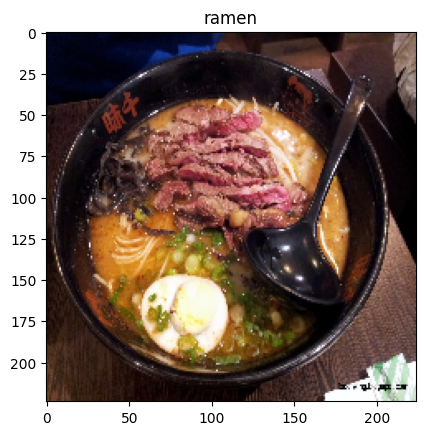

1/1 [==============================] - 0s 26ms/step
Predicted food for /content/AdobeStock_808308463_Preview.jpeg: french_onion_soup


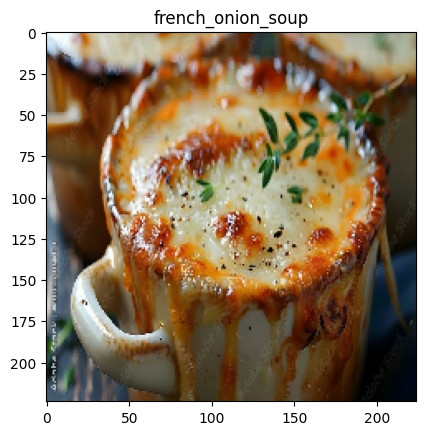

1/1 [==============================] - 0s 26ms/step
Predicted food for /content/food-3338312_1280.jpg: tiramisu


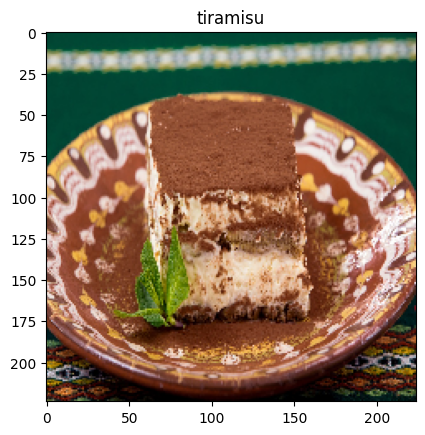

1/1 [==============================] - 0s 24ms/step
Predicted food for /content/AdobeStock_259557054_Preview.jpeg: takoyaki


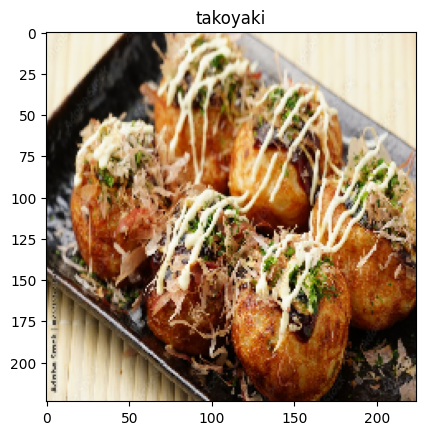

1/1 [==============================] - 0s 25ms/step
Predicted food for /content/Screenshot 2024-05-11 at 2.12.08 PM.png: tuna_tartare


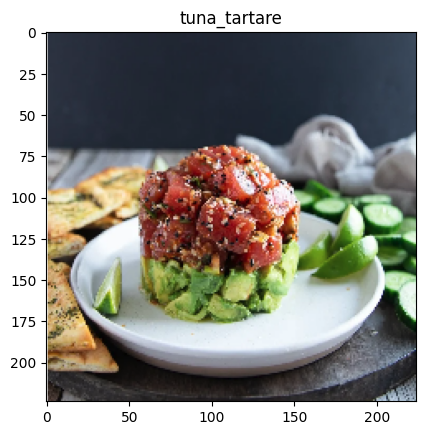

1/1 [==============================] - 0s 26ms/step
Predicted food for /content/mussel-food-bivalve-shellfish-1910345.jpg: mussels


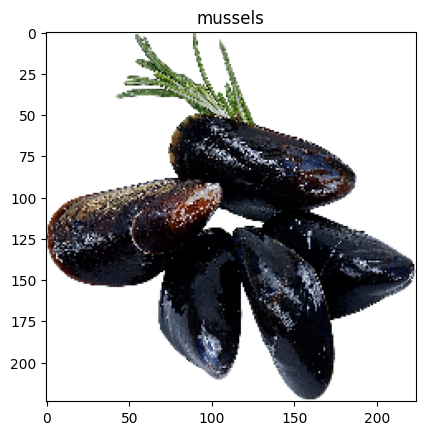

In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = load_model('/content/Resnet-50_model_trained_3class.hdf5')

# Create a reverse mapping
class_indices = train_generator.class_indices
reverse_mapping = {v: k for k, v in class_indices.items()}

# List of image paths you want to classify
img_paths = ['/content/693689.jpg','/content/AdobeStock_808308463_Preview.jpeg','/content/food-3338312_1280.jpg', '/content/AdobeStock_259557054_Preview.jpeg', '/content/Screenshot 2024-05-11 at 2.12.08 PM.png', '/content/mussel-food-bivalve-shellfish-1910345.jpg' ]

for img_path in img_paths:
    # Load the image
    img = image.load_img(img_path, target_size=IMAGE_SIZE)

    # Preprocess the image for the model
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Rescale the same way as the training data

    # Predict the class of the image
    predictions = model.predict(x)
    predicted_class = np.argmax(predictions[0])

    # Get the food name from the predicted class number
    predicted_food_name = reverse_mapping[predicted_class]

    # Print the predicted food name
    print(f'Predicted food for {img_path}:', predicted_food_name)

    # Display the image along with the predicted label
    plt.imshow(img)
    plt.title(predicted_food_name)
    plt.show()